# Homework assignment - Traffic Signs

This notebook is the stub you have to fill out for the homework. Read the task description and implement the empty code cells. Each section represents a stage along implementing an image classifier from loading and inspecting the dataset to making something working. The section descriptions contain what to do in that step.


Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [canvas.elte.hu](canvas.elte.hu). If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU acceleration in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Task description
Your task is to implement a deep learning classifier of traffic signs. The dataset is based on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). It has already been preprocessed for convenience. The implemented network is a variation of Yann LeCun's classic LeNet network, with different layers and layer shapes compared to the original.

## Rules and Comments
- As always, copying others' code will make you fail the homework automatically (and thus the course)
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- To ease grading, please keep all outputs in the notebook before submission.
- Feel free to add more code cells as needed. But please don't put code into external Python files to ease the reviewing.
- Please add your name and Neptune ID in the box below for easier identification.

**Name: Kevin Hartyányi**  
**Neptun ID: C0S0RJ** 

In [1]:
# Some useful imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

## Dataset preparations
First download the data and extract it:

In [2]:
!wget http://vegesm.web.elte.hu/traffic_sign_train.pkl
!wget http://vegesm.web.elte.hu/traffic_sign_test.pkl
!wget http://vegesm.web.elte.hu/signnames.csv

--2020-11-28 13:03:03--  http://vegesm.web.elte.hu/traffic_sign_train.pkl
Resolving vegesm.web.elte.hu (vegesm.web.elte.hu)... 157.181.1.225
Connecting to vegesm.web.elte.hu (vegesm.web.elte.hu)|157.181.1.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120724859 (115M) [text/plain]
Saving to: ‘traffic_sign_train.pkl.3’

traffic_sign_train. 100%[===================>] 115.13M  17.7MB/s    in 20s     

2020-11-28 13:03:24 (5.65 MB/s) - ‘traffic_sign_train.pkl.3’ saved [120724859/120724859]

--2020-11-28 13:03:24--  http://vegesm.web.elte.hu/traffic_sign_test.pkl
Resolving vegesm.web.elte.hu (vegesm.web.elte.hu)... 157.181.1.225
Connecting to vegesm.web.elte.hu (vegesm.web.elte.hu)|157.181.1.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38888118 (37M) [text/plain]
Saving to: ‘traffic_sign_test.pkl.3’

traffic_sign_test.p 100%[===================>]  37.09M  7.70MB/s    in 12s     

2020-11-28 13:03:37 (3.04 MB/s) - ‘traffic_sign_te

In [3]:
with open('traffic_sign_test.pkl', 'rb') as f:
    test = pickle.load(f)
with open('traffic_sign_train.pkl', 'rb') as f:
    train = pickle.load(f)
    
x_test, y_test = test['features'], test['labels']
x_train, y_train = train['features'], train['labels']

In [4]:
df = pd.read_csv("signnames.csv")
label_num = len(df)
label_num

43

The dataset contains 32x32 pixel images of traffic signs. The signnames.csv contains the name and id of each class. You might want to use it for inspecting the data.

Notice that the original dataset does not define a validation set, you have to split it yourself. Split the training set into a training and validation set. Make sure in the validation set the classes have a similar distribution to the training set. [1p]



In [5]:
# ADD YOUR CODE HERE
# It should create the variables x_train, y_train, x_valid, y_valid
# The training and validation set must be disjoint
"""
validation_size = int(0.15 * len(y_train))
permutation = np.random.permutation(len(y_train))
x_train = x_train[permutation]
y_train = y_train[permutation]

x_val = x_train[:validation_size]
y_val = y_train[:validation_size]

x_train = x_train[validation_size:]
y_train = y_train[validation_size:]
"""
from sklearn.model_selection import train_test_split

val_size = 0.1
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size)

print("Train size:", len(y_train))
print("Validation size:", len(y_val))
print("Test size:", len(y_test))

Train size: 35288
Validation size: 3921
Test size: 12630


Now that you have set up the dataset, it's time to look at some of the images. Create a function that randomly selects 4 images from a class and shows them. [1p]

In [6]:
def draw_images(imgs, labels, class_to_draw):
    """
    imgs - a numpy array of size Nx32x32x3 where N is the number of images. imgs contains the 32x32 pixel images
    labels - array of length N, the class id of the images
    class_to_draw - id of the class from which to select images
    """
    # IMPLEMENT YOUR CODE HERE
    class_indexes = np.where(labels == class_to_draw)[0]
    indexes = np.random.choice(class_indexes, 4)
    _, ax = plt.subplots(1,4, figsize=(20,20))
    for i, ind in enumerate(indexes):
      ax[i].imshow(imgs[ind])

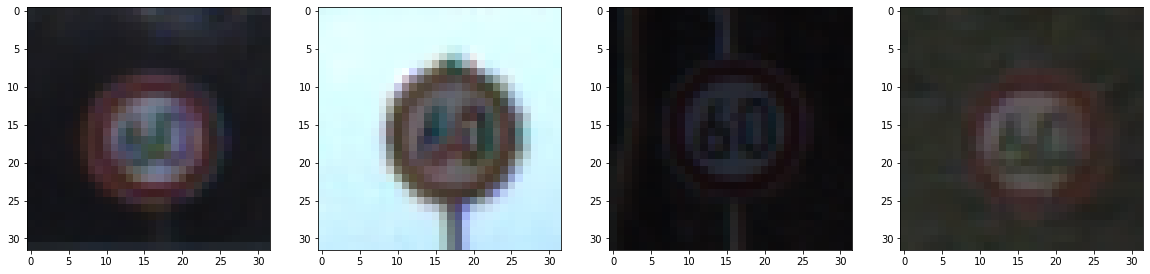

In [7]:
# Show some 50 km/h speed limit signs (class #3)
draw_images(x_train, y_train, 3)

First, you should normalize the data. Apply a normalisation method of your choice that brings the data around 0, to the scale of 0-1.

Note: you may want to convert the datatype of `x_train` and `x_test` to float32 instead of the original uint8. Fractional values are not representable with a `uint8` datatype. [2p]

In [8]:
# ADD YOUR CODE HERE
# IT SHOULD MODIFY x_train, and x_test the same way
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)
x_test = x_test.astype(np.float32)

def std_normalization(data):
    # params: data: ndarray(n_samples, n_features)
    data = np.asarray(data, dtype=np.float64)
    eps = 0.0000001
    x_mean = np.mean(data, axis=0)
    x_std = np.std(data, axis=0)
    x_norm = (data-x_mean) / (x_std + eps)
    
    return x_norm, x_mean, x_std
  
def std_normalize_with_given_meanstd(data, x_mean, x_std):
    eps = 0.0000001
    x_norm = (data-x_mean) / (x_std + eps)
    return x_norm

x_train, x_mean, x_std = std_normalization(x_train)

x_val = std_normalize_with_given_meanstd(x_val, x_mean, x_std)
x_test = std_normalize_with_given_meanstd(x_test, x_mean, x_std)

## Training the network

Implement and train the following modified LeNet architecture. It has the following layers:

- A convolutional layer with 3x3 kernel and 8 filters
- An AveragePooling layer
- A convolutional layer with 3x3 kernel and 16 filters
- An AveragePooling layer
- A fully connected layer of 100 units
- A fully connected layer of 80 units
- A fully connected layer with softmax activation, having the same number of units as classes

All layers have ReLU activations. Train the network for 50 epochs. [6p]

In [9]:
x_train.shape[1:]

(32, 32, 3)

In [10]:
# ADD YOUR CODE HERE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Flatten, Dropout

model = Sequential()
model.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(AveragePooling2D())
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=80, activation='relu'))
model.add(Dense(units=label_num, activation = 'softmax'))

In [11]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 8)         224       
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 16)        1168      
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               57700     
_________________________________________________________________
dense_1 (Dense)              (None, 80)                8

In [13]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val)) 

Epoch 1/50
1103/1103 [==============================] - 4s 3ms/step - loss: 1.1166 - accuracy: 0.6852 - val_loss: 0.3880 - val_accuracy: 0.8860
Epoch 2/50
1103/1103 [==============================] - 3s 3ms/step - loss: 0.2897 - accuracy: 0.9154 - val_loss: 0.2258 - val_accuracy: 0.9380
Epoch 3/50
1103/1103 [==============================] - 3s 3ms/step - loss: 0.1803 - accuracy: 0.9484 - val_loss: 0.1783 - val_accuracy: 0.9457
Epoch 4/50
1103/1103 [==============================] - 3s 3ms/step - loss: 0.1265 - accuracy: 0.9642 - val_loss: 0.1456 - val_accuracy: 0.9643
Epoch 5/50
1103/1103 [==============================] - 3s 3ms/step - loss: 0.1031 - accuracy: 0.9709 - val_loss: 0.1586 - val_accuracy: 0.9572
Epoch 6/50
1103/1103 [==============================] - 3s 3ms/step - loss: 0.0785 - accuracy: 0.9765 - val_loss: 0.1241 - val_accuracy: 0.9666
Epoch 7/50
1103/1103 [==============================] - 3s 3ms/step - loss: 0.0654 - accuracy: 0.9812 - val_loss: 0.1215 - val_accuracy:

Now, that the model has finished training, plot the accuracy and loss over time, both for training and validation data [1p]:

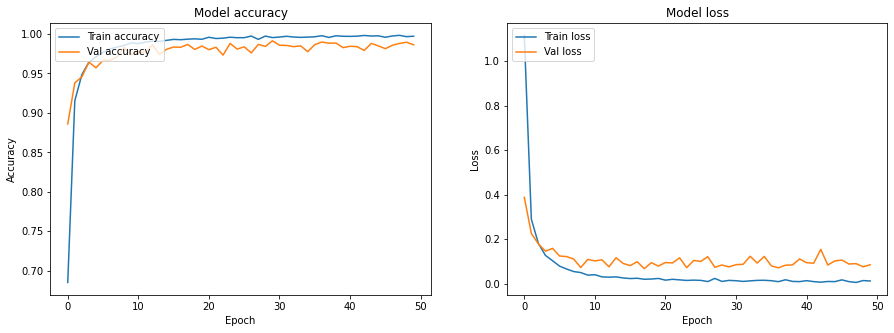

In [14]:
# ADD YOUR CODE HERE
def plot_hist(hist):
  _, ax = plt.subplots(1,2, figsize=(15,5))
  ax[0].plot(hist.history['accuracy'])
  ax[0].plot(hist.history['val_accuracy'])
  ax[0].set_title('Model accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend(['Train accuracy', 'Val accuracy'], loc='upper left')

  ax[1].plot(hist.history['loss'])
  ax[1].plot(hist.history['val_loss'])
  ax[1].set_title('Model loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend(['Train loss', 'Val loss'], loc='upper left');
  plt.plot()
plot_hist(history)

How did the loss and accuracy curves change over time? What does it mean regarding the training process (i.e. overfit, underfit, etc.)? Is that a problem and how would you solve it? [3p]

**Write your answers below**

Answer:<br>
The training loss keeps decreasing, while the validation loss doesn't decrease after some point over time. This means that the model overfits. <br>It is a problem. Things that we can try to prevent it:
- Regularization
- More data
- Remove features

Finally, calculate the performance of your model on the test set [1p]:

In [15]:
# ADD YOUR CODE HERE
loss, acc = model.evaluate(x_test, y_test)

print("Test loss: ", loss)
print("Test accuracy: ", acc)

395/395 [==============================] - 1s 2ms/step - loss: 0.6831 - accuracy: 0.9238
Test loss:  0.6831462383270264
Test accuracy:  0.9238321185112


# Parameter tuning

We have created a baseline model successfully, it is time to optimise the parameters. Try out all the following and write a short summary on the results. The summary should include the performance differences between the models, which one was the best and why. [6p]

Different settings:
  - add dropout after the fully conencted layers
  - add an extra convolutional layer with 16 channels
  - try different learning rates between 1e-5 and 1e-2

In [16]:
def train(m):
  h = m.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), verbose=2) 
  plot_hist(h)
  loss, acc = m.evaluate(x_test, y_test)
  print("Test loss: ", loss)
  print("Test accuracy: ", acc)
  return loss

In [17]:
# ADD YOUR CODE HERE
# Dropout
model_drop = Sequential()
model_drop.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model_drop.add(AveragePooling2D())
model_drop.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model_drop.add(AveragePooling2D())
model_drop.add(Flatten())
model_drop.add(Dense(units=100, activation='relu'))
model_drop.add(Dropout(0.2))
model_drop.add(Dense(units=80, activation='relu'))
model_drop.add(Dropout(0.2))
model_drop.add(Dense(units=label_num, activation = 'softmax'))
model_drop.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_drop.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 8)         224       
_________________________________________________________________
average_pooling2d_2 (Average (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 16)        1168      
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               57700     
_________________________________________________________________
dropout (Dropout)            (None, 100)              

Epoch 1/50
1103/1103 - 3s - loss: 1.5638 - accuracy: 0.5383 - val_loss: 0.5133 - val_accuracy: 0.8539
Epoch 2/50
1103/1103 - 3s - loss: 0.4974 - accuracy: 0.8421 - val_loss: 0.2533 - val_accuracy: 0.9248
Epoch 3/50
1103/1103 - 3s - loss: 0.3154 - accuracy: 0.9033 - val_loss: 0.1709 - val_accuracy: 0.9523
Epoch 4/50
1103/1103 - 3s - loss: 0.2343 - accuracy: 0.9277 - val_loss: 0.1207 - val_accuracy: 0.9694
Epoch 5/50
1103/1103 - 3s - loss: 0.1897 - accuracy: 0.9421 - val_loss: 0.0999 - val_accuracy: 0.9727
Epoch 6/50
1103/1103 - 3s - loss: 0.1638 - accuracy: 0.9483 - val_loss: 0.0810 - val_accuracy: 0.9778
Epoch 7/50
1103/1103 - 3s - loss: 0.1364 - accuracy: 0.9585 - val_loss: 0.0960 - val_accuracy: 0.9717
Epoch 8/50
1103/1103 - 3s - loss: 0.1250 - accuracy: 0.9611 - val_loss: 0.0711 - val_accuracy: 0.9824
Epoch 9/50
1103/1103 - 3s - loss: 0.1127 - accuracy: 0.9649 - val_loss: 0.0663 - val_accuracy: 0.9834
Epoch 10/50
1103/1103 - 3s - loss: 0.0983 - accuracy: 0.9695 - val_loss: 0.0579 - 

0.40068215131759644

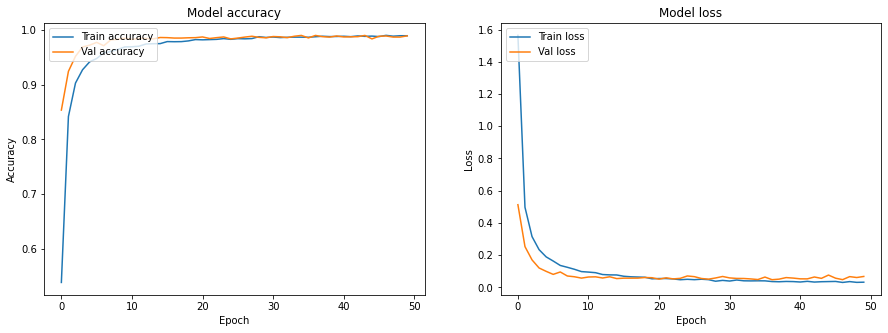

In [18]:
train(model_drop)

In [19]:
# Extra Conv
model_conv = Sequential()
model_conv.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model_conv.add(AveragePooling2D())
model_conv.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model_conv.add(AveragePooling2D())
model_conv.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model_conv.add(AveragePooling2D())
model_conv.add(Flatten())
model_conv.add(Dense(units=100, activation='relu'))
model_conv.add(Dense(units=80, activation='relu'))
model_conv.add(Dense(units=label_num, activation = 'softmax'))
model_conv.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_conv.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 8)         224       
_________________________________________________________________
average_pooling2d_4 (Average (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 16)        1168      
_________________________________________________________________
average_pooling2d_5 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 16)          2320      
_________________________________________________________________
average_pooling2d_6 (Average (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)               

Epoch 1/50
1103/1103 - 3s - loss: 1.8304 - accuracy: 0.4579 - val_loss: 1.0743 - val_accuracy: 0.6419
Epoch 2/50
1103/1103 - 3s - loss: 0.8279 - accuracy: 0.7335 - val_loss: 0.7000 - val_accuracy: 0.7677
Epoch 3/50
1103/1103 - 3s - loss: 0.5539 - accuracy: 0.8190 - val_loss: 0.4732 - val_accuracy: 0.8465
Epoch 4/50
1103/1103 - 3s - loss: 0.3987 - accuracy: 0.8717 - val_loss: 0.3949 - val_accuracy: 0.8745
Epoch 5/50
1103/1103 - 3s - loss: 0.3090 - accuracy: 0.9014 - val_loss: 0.3013 - val_accuracy: 0.9092
Epoch 6/50
1103/1103 - 4s - loss: 0.2477 - accuracy: 0.9214 - val_loss: 0.2579 - val_accuracy: 0.9217
Epoch 7/50
1103/1103 - 3s - loss: 0.2055 - accuracy: 0.9353 - val_loss: 0.2224 - val_accuracy: 0.9314
Epoch 8/50
1103/1103 - 3s - loss: 0.1772 - accuracy: 0.9432 - val_loss: 0.2467 - val_accuracy: 0.9212
Epoch 9/50
1103/1103 - 3s - loss: 0.1554 - accuracy: 0.9507 - val_loss: 0.2005 - val_accuracy: 0.9388
Epoch 10/50
1103/1103 - 3s - loss: 0.1355 - accuracy: 0.9573 - val_loss: 0.1939 - 

0.8846418857574463

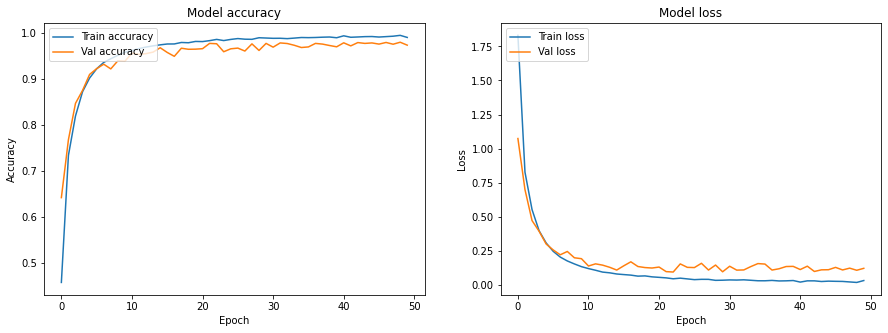

In [20]:
train(model_conv)

Epoch 1/50
1103/1103 - 3s - loss: 3.6375 - accuracy: 0.0719 - val_loss: 3.5021 - val_accuracy: 0.1163
Epoch 2/50
1103/1103 - 3s - loss: 3.3638 - accuracy: 0.1507 - val_loss: 3.2462 - val_accuracy: 0.1619
Epoch 3/50
1103/1103 - 3s - loss: 3.1272 - accuracy: 0.2073 - val_loss: 3.0190 - val_accuracy: 0.2341
Epoch 4/50
1103/1103 - 3s - loss: 2.9164 - accuracy: 0.2578 - val_loss: 2.8186 - val_accuracy: 0.2739
Epoch 5/50
1103/1103 - 3s - loss: 2.7209 - accuracy: 0.2999 - val_loss: 2.6322 - val_accuracy: 0.3076
Epoch 6/50
1103/1103 - 3s - loss: 2.5407 - accuracy: 0.3372 - val_loss: 2.4606 - val_accuracy: 0.3443
Epoch 7/50
1103/1103 - 3s - loss: 2.3773 - accuracy: 0.3673 - val_loss: 2.3074 - val_accuracy: 0.3734
Epoch 8/50
1103/1103 - 3s - loss: 2.2332 - accuracy: 0.3955 - val_loss: 2.1751 - val_accuracy: 0.4065
Epoch 9/50
1103/1103 - 3s - loss: 2.1060 - accuracy: 0.4249 - val_loss: 2.0545 - val_accuracy: 0.4343
Epoch 10/50
1103/1103 - 3s - loss: 1.9942 - accuracy: 0.4515 - val_loss: 1.9536 - 

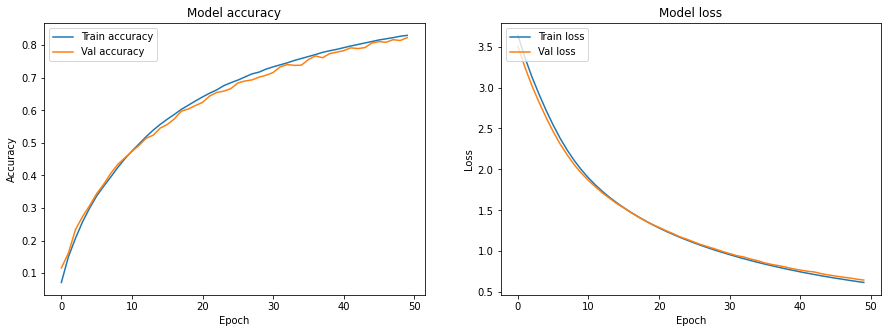

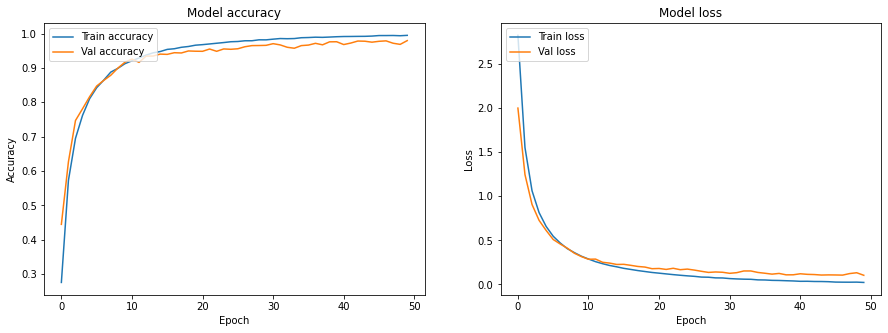

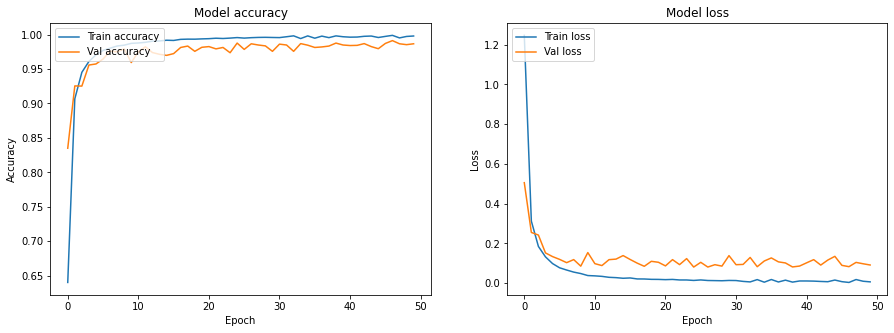

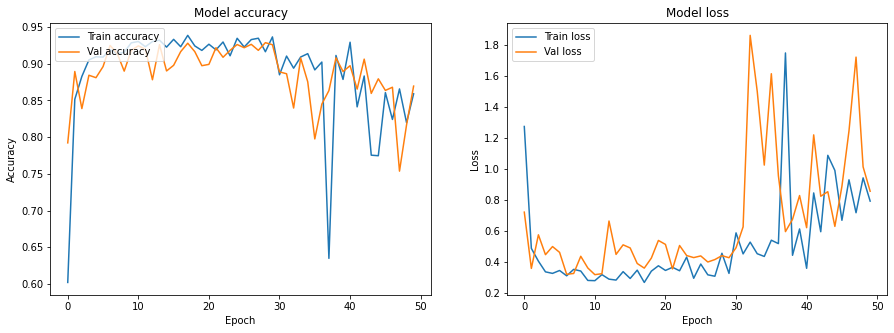

In [21]:
# Learning rates

def base_model():
  re = Sequential()
  re.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
  re.add(AveragePooling2D())
  re.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  re.add(AveragePooling2D())
  re.add(Flatten())
  re.add(Dense(units=100, activation='relu'))
  re.add(Dense(units=80, activation='relu'))
  re.add(Dense(units=label_num, activation = 'softmax'))
  return re


learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
losses = []
for lr in learning_rates:
  m = base_model()
  opt = tf.keras.optimizers.Adam(learning_rate=lr)
  m.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  losses.append(train(m))
print(learning_rates)
print(losses)

In [26]:
print("Learning rates and losses:")
print(*zip(learning_rates, losses))

Learning rates and losses:
(1e-05, 1.0981699228286743) (0.0001, 0.940482497215271) (0.001, 0.9027022123336792) (0.01, 7.69772481918335)


**Original test loss: 0.6831462383270264**

**Dropout:**
- test loss: 0.40068215131759644

**Extra Convolutional Layer:**
- test loss: 0.8846418857574463

**Different Learning Rates:**
- lr:1e-05 , test loss: 1.0981699228286743
- lr:0.0001, test loss: 0.940482497215271
- lr: 0.001, test loss: 0.9027022123336792
- lr: 0.01, test loss: 7.69772481918335


The best one is the dropout.<br>
Reason:  <br>
Thanks to the dropout layers the network becomes less sensitive to the specific weights of neurons. This results in a network that is capable of better generalization and is less likely to overfit the training data.